# 0. Environment Setup

## Mount Google Drive

To access the GitHub project and associated files, you need to mount your Google Drive to Colab. This process allows you to read and write files directly from your Google Drive within the Colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Set your parameters

Please make sure to update the following parameters to your own:

- **Project ID**: The BigQuery project ID to query the MIMIC-III v1.4 raw data. (If you're not sure what your project ID is, check details in `notebooks/MIMIC_III_Data_Access_Instructions.ipynb`.)
- **BASE_PATH**: The path where the GitHub project will be cloned.

In [ ]:
# Remember to update the BigQuery project ID to your own to query raw data
PROJECT_ID = 'sepsis-mimic3'

# Remember to update this variable to your own path
# BASE_PATH is where the GitHub project will be cloned
BASE_PATH = "/content/drive/MyDrive/GitHub_Testing"

## Importing libraries.

In [ ]:
%cd {BASE_PATH}/SepsisOnset_TraumaCohort

import os
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from matplotlib import pyplot as plt

# for dataset
# from scripts.all_icu_data import load_or_generate_nighttime_df
# for model
from tensorflow.keras.utils import to_categorical

# Initialize the ProjectPaths object
from src import path_manager
project_path_obj = path_manager.ProjectPaths(f'{BASE_PATH}/SepsisOnset_TraumaCohort')

In [ ]:
MODEL_FOLDER = '/content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model'
DATA_FOLDER = project_path_obj.final_dataset_path

## Load Dataset

### All ICU Data

In [ ]:
file_path = os.path.join(DATA_FOLDER, 'nighttime_allICU_18to6H_7F_filled_final.pkl')

if os.path.exists(file_path):
    print(f"Loading existing nighttime data from {file_path}")
    night_ti_df = pd.read_pickle(file_path)
else:
    print(f"File not found: {file_path}")

print(night_ti_df.shape)
# Drop Nan
is_any_nan = night_ti_df['Temporal Features'].apply(lambda x: np.isnan(x).any())
night_df_filled = night_ti_df[~is_any_nan]
night_df_filled

### Trauma Cohot
In this section, we will load the complete Post-Traumatic Sepsis dataset (without missing values), which is derived from the MIMIC-III v1.4 dataset. For a comprehensive explanation of the dataset construction and additional relevant information, please refer to the `notebooks/Early_Sepsis_Onset_Detection_Setup.ipynb` file.

The dataset table comprises the following columns:

- **Temporal Features**: Multivariate time-series input data with dimensions (# of timestamps, # of features).

Each row in the dataset corresponds to one nighttime instance, and includes patient identifiers (`subject_id`, `hadm_id`) and a timestamp ID (`Date`, `Night`).

In [ ]:
file_path = os.path.join(DATA_FOLDER, 'PostTraumaticSepsis_dataset_wo_nan.pkl')

if os.path.exists(file_path):
    print(f"Loading existing nighttime data from {file_path}")
    truma_cohort_df = pd.read_pickle(file_path)
else:
    print(f"File not found: {file_path}")

truma_cohort_ids = truma_cohort_df.hadm_id.unique()
positive_samples = truma_cohort_df[truma_cohort_df.Label == 1]
print("# of truma", truma_cohort_ids.shape[0],
      f"# of positive sample {positive_samples.shape[0]} of sepsis pacient {positive_samples.hadm_id.nunique()}")
truma_cohort_df.head()

In [ ]:
truma_subject_ids = truma_cohort_df.subject_id.unique()

truma_records = night_df_filled[night_df_filled.subject_id.isin(truma_subject_ids)]
nontruma_records = night_df_filled[~night_df_filled.subject_id.isin(truma_subject_ids)]
print(truma_records.shape, nontruma_records.shape)

## Sample

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_nighttime_features(
    sample: np.array,
    feature_names: list[str],
    start_hour: int = 18,
    title: str = "Nighttime Features (6 pm → 6 am)"
) -> pd.DataFrame:
    """
    Build a DataFrame indexed from start_hour through next-day 6 am,
    then plot all features over that 13-hour window.

    Parameters
    ----------
    sample : array-like, shape (T=13, F)
        2D array of T hourly measurements.
    feature_names : list of str, length F
        Column names for each feature.
    start_hour : int, optional
        Hour to start labeling (default 18 for 6 pm).
    title : str, optional
        Plot title.

    Returns
    -------
    sample_df : pd.DataFrame
        DataFrame of the sample, indexed by hour labels.
    """
    T = sample.shape[0]
    # generate labels "18:00, 19:00, …, 23:00, 00:00, …, 06:00"
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # build DataFrame with custom index
    sample_df = pd.DataFrame(sample, columns=feature_names, index=hour_labels)
    # display(sample_df)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    for col in sample_df.columns:
        ax.plot(sample_df.index, sample_df[col], label=col)

    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1),   # (x, y) relative to axes

              )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return sample_df

In [ ]:
print(night_df_filled['Temporal Features'][0].shape) #T:13(6pm-6am), F:['HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2']

sample = night_df_filled['Temporal Features'][0]
feature_names = ['HeartRate', 'SysBP', 'DiasBP', 'MeanBP',
                 'RespRate', 'TempC', 'SpO2', #'Glucose', 'fio2'
                 ]
plot_nighttime_features(sample, feature_names=feature_names,
                        start_hour=18, title= "Night Sample(6 pm–6 am)")

In [ ]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_nighttime_features_subplots(
    sample: np.array,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Nighttime Features"
) -> pd.DataFrame:
    """
    Plot each feature in its own subplot over the 13-hour window,
    arranged in a grid with `ncols` columns.
    Each subplot shows its own x-axis labels.

    Returns the DataFrame for further inspection.
    """
    T, F = sample.shape
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]
    sample_df = pd.DataFrame(sample, columns=feature_names, index=hour_labels)

    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, col in enumerate(feature_names):
        ax = axes_flat[idx]
        ax.plot(range(T), sample_df[col], label=col)
        ax.set_ylabel(col)
        ax.grid(True)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)

    # 关闭多余的子图
    for ax in axes_flat[F:]:
        ax.axis('off')

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return sample_df


plot_nighttime_features_subplots(sample, feature_names=feature_names,
                        start_hour=18, title_prefix= "Night Sample(6 pm–6 am)")

In [ ]:
# corrspondng features list: 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2', 'Glucose', 'fio2'
start_hour, T = 18,13
pd.DataFrame(night_df_filled.isNan[0], columns=['HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'TempC', 'SpO2',
                                                # 'Glucose', 'fio2'
                                                ],
             index=[f"{(start_hour + i) % 24:02d}:00" for i in range(T)])
# False: means not nan, or have raw data
# True: is nan, data is filled

# Model

## Model Definition

In [ ]:
keras.layers.GRU

In [ ]:
from keras import layers, models, Input
from keras.regularizers import l2

def Encoder_model(input_shape, name="encoder", drop_r=0.2):
    input_layer = Input(shape=input_shape)
    x = input_layer

    # RNN Feature Extraction
    x = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001),
                                        reset_after=True
                                        ))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001),
                                        reset_after=True
                                        ))(x)
    x = layers.BatchNormalization()(x)

    # TCNN
    # Feed Forward Part
    x = layers.Conv1D(filters=128, kernel_size=3, strides=1,
                      activation="relu", kernel_regularizer=l2(0.01),
                      # dilation_rate=1
                      )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=drop_r)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, strides=2,
                      # dilation_rate=1s
                      )(x)
    x = layers.BatchNormalization()(x)

    # Output Feature Representation Vector
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    # x = layers.GlobalMaxPooling1D()(x)

    return models.Model(input_layer, x, name=name)

def multimodal_AutoEncoder(input_shape_li, drop_r=0.2):
    # Create input layers for each encoder
    raw_inputs = layers.Input(shape=input_shape_li[0])
    delta_inputs = layers.Input(shape=input_shape_li[1])
    inputs = [raw_inputs, delta_inputs]

    # Init Encoders
    raw_encoder = Encoder_model(input_shape_li[0], name="night_encoder")
    delta_encoder = Encoder_model(input_shape_li[1], name="delta_encoder")
    encoders = [raw_encoder, delta_encoder]

    # Pass inputs through respective encoders
    embeddings = [raw_encoder(raw_inputs),
                  delta_encoder(delta_inputs)]
    # Combine the embeddings (using Concatenate)
    combined_emb = layers.Concatenate()(embeddings)
    # # Combine the embeddings (using Add)
    # combined_emb = layers.Add()(embeddings)

    # Decoder
    # feature_vector_shape=encoder.output_shape
    # latent_inputs = Input(shape=feature_vector_shape[1:])
    T, F = input_shape_li[0]
    x = layers.RepeatVector(n=T)(combined_emb)
    # x = layers.LSTM(units=1, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = layers.Bidirectional(layers.GRU(units=64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=drop_r)(x)
    x = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=drop_r)(x)
    decoder_output = layers.TimeDistributed(layers.Dense(units=F, kernel_regularizer=l2(0.01)))(x)

    # Autoencoder
    autoencoder = models.Model(inputs, decoder_output, name="autoencoder")
    return encoders, autoencoder

input_shape_li = [(9, 6), (9,6)]
encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)

In [ ]:
night_df_filled['Temporal Features'][0].shape

In [ ]:
input_shape_li = [(13, 7), (13,7)]
# encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
raw_encoder = Encoder_model(input_shape_li[0], name="night_encoder")
keras.utils.plot_model(raw_encoder, show_shapes=True, show_layer_names=True)

In [ ]:
# Instantiate the models
input_shape_li = [(9, 6), (9,6)]
encoders, autoencoder = multimodal_AutoEncoder(input_shape_li)

# # Print summary of the autoencoder model
encoders[0].summary()
# encoders[1].summary()
autoencoder.summary()

keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True)

## Custom Fit and Loss Functions

In [ ]:
def masked_mae(y_true, y_pred, mask, alpha=1.0):
    """
    Weighted MAE for Masked-AE.
    alpha = mask_weight_para in [0, 1]:
        1.0 → loss from masked positions only
        0.5 → half masked, half visible
        0.0 → all positions equally
    """
    # element-wise L1 error
    err = tf.abs(y_true - y_pred)

    # visible = 1, masked = 0  ▸ convert to float32
    mask = tf.cast(mask, tf.float32)

    # build weights: w = (1-alpha)·visible + alpha·masked
    weights = (1.0 - alpha) * mask + alpha * (1.0 - mask)

    # masked mean
    loss = tf.reduce_sum(err * weights) / tf.reduce_sum(weights)
    return loss


In [ ]:
class MaskedReconstructionFit(tf.keras.Model):
    def __init__(self, model, alpha=1.0):
        super(MaskedReconstructionFit, self).__init__()
        self.model = model
        self.alpha = alpha         # mask_weight_para
        # self.loss_fn = weight_mae
        # self.test_loss_fn = tf.keras.losses.MeanAbsoluteError()
        self.metric = tf.keras.metrics.MeanAbsoluteError()

    def compile(self, optimizer, metrics=None, **kwargs):
        super().compile(optimizer=optimizer, metrics=metrics, **kwargs)

    def train_step(self, data):
        (x, x_delta), mask = data  # data should be in the form (x, delta, mask)
        mask = tf.cast(mask, tf.float32)
        masked_x = x * mask  # Apply the mask to the input
        # masked_x_delta = x_delta * mask
        # tf.print("Masked input (masked_x):", masked_x, summarize=-1)  # summarize=-1 prints the full tensor

        with tf.GradientTape() as tape:
            x_hat = self.model([masked_x, x_delta], training=True)
            loss  = masked_mae(x, x_hat, mask, self.alpha)

        # Compute gradients and update weights
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Update the reconstruction loss metric
        self.metric.update_state(x, x_hat)
        # Return the reconstruction loss as the only metric
        return {"loss": loss, "global_MAE": self.metric.result()}



    def test_step(self, data):
        (x, x_delta), mask = data  # data should be in the form (x, delta, mask)
        mask = tf.cast(mask, tf.float32)
        x_visible = x * mask              # zero-out masked positions

        x_hat = self.model([x_visible, x_delta], training=False)
        loss  = masked_mae(x, x_hat, mask, self.alpha)

        # Update the reconstruction loss metric
        self.metric.update_state(x, x_hat)
        # ---- build log dict (TOP-LEVEL keys!) ----
        return {"loss": loss, "global_MAE":self.metric.result()}


## Evaluation and Learning Curve Plotting Function

In [ ]:


# # Define the function to plot learning curves
# def plot_learning_curves(history):
#     """
#     Plot the learning curves for training and validation loss/accuracy.

#     Parameters:
#     - history: The history object returned from model.fit.

#     Returns:
#     - None
#     """
#     history = history.history

#     # Loop through each metric in the history
#     for metric in history.keys():
#       if 'val' not in metric:
#         epochs = range(1, len(history[metric]) + 1)

#         plt.figure(figsize=(4, 3))
#         plt.plot(epochs, history[metric], label=metric)
#         plt.plot(epochs, history[f'val_{metric}'], label=f'Validation')
#         plt.title(f'{metric.capitalize()} over Epochs')
#         plt.xlabel('Epochs')
#         plt.ylabel(metric.capitalize())
#         plt.legend()
#         plt.grid(True)
#         plt.show()
# plot_learning_curves(history)

def plot_learning_curves(training_history, name='', metric_name_li=[]):
    """
    Plots the learning curves for training and validation loss/accuracy.

    Parameters:
    - training_history: The history object returned from model.fit.

    Returns:
    - None (Displays the plots).
    """
    history_data = training_history.history

    # Loop through each metric in the history
    if len(metric_name_li) == 0:
      for metric_name in history_data.keys():
          if 'val' not in metric_name:
              metric_name_li.append(metric_name)

    for metric_name in metric_name_li:
            epochs = range(1, len(history_data[metric_name]) + 1)

            # Create a new figure for each metric
            metric_fig = plt.figure(figsize=(4, 3))
            plt.plot(epochs, history_data[metric_name], label=f'Training {metric_name}')
            plt.plot(epochs, history_data[f'val_{metric_name}'], label=f'Validation {metric_name}')

            # Formatting the plot
            plt.title(f'{metric_name.capitalize()}-{name}')
            plt.xlabel('Epochs')
            plt.ylabel(metric_name.capitalize())
            plt.legend()
            plt.grid(True)

            # Display the plot
            # metric_fig.tight_layout()
            metric_fig.show()
    return


## Save Model

In [ ]:
from tensorflow.keras.models import save_model

def save_models(encoders, autoencoder, save_dir):
    """
    Saves encoders (list of two models) and autoencoder model to the given directory.

    Parameters:
    - encoders (list): A list containing two Keras models (encoder models).
    - autoencoder (Model): The main autoencoder model.
    - save_dir (str): Directory path where models will be saved.

    Returns:
    - None (saves models to disk).
    """

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save encoder models
    save_model(encoders[0], os.path.join(save_dir, "encoder_1.h5"))
    save_model(encoders[1], os.path.join(save_dir, "encoder_2.h5"))

    # Save autoencoder model
    save_model(autoencoder, os.path.join(save_dir, "autoencoder.h5"))

    print(f"Models saved in: {save_dir}")


from tensorflow.keras.models import load_model
def load_models(load_dir, load_autoencoder=True):
    """
    Loads two encoder models and optionally an autoencoder model from the specified directory.

    Parameters:
    - load_dir (str): Directory path where models are saved.
    - load_autoencoder (bool): Whether to load the autoencoder model (default is True).

    Returns:
    - encoders (list): A list containing two loaded encoder models.
    - autoencoder (Model or None): The loaded autoencoder model if `load_autoencoder=True`, else None.
    """

    # Ensure the directory exists
    if not os.path.exists(load_dir):
        raise FileNotFoundError(f"Directory {load_dir} does not exist. Please check the path.")

    # Load encoder models
    encoder_1 = load_model(os.path.join(load_dir, "encoder_1.h5"))
    encoder_2 = load_model(os.path.join(load_dir, "encoder_2.h5"))

    encoders = [encoder_1, encoder_2]

    # Load autoencoder model if specified
    autoencoder = None
    if load_autoencoder:
        autoencoder = load_model(os.path.join(load_dir, "autoencoder.h5"))
        print(f"Autoencoder loaded successfully from: {load_dir}")

    print(f"Encoders loaded successfully from: {load_dir}")

    return encoders, autoencoder


# Data Preprocess

## Sampling with mask strategy

In [ ]:
from sklearn.utils import shuffle

def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked
    Returns:
        (L,) boolean numpy array intended to mask ('drop') with 0s a sequence of length L
    """
    # np.random.seed(seed)
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask

def noise_mask(X, masking_ratio, lm=3, mode='separate', distribution='geometric', exclude_feats=None):
    """
    Creates a random boolean mask of the same shape as X, with 0s at places where a feature should be masked.
    Args:
        X: (seq_length, feat_dim) numpy array of features corresponding to a single sample
        masking_ratio: proportion of seq_length to be masked. At each time step, will also be the proportion of
            feat_dim that will be masked on average
        lm: average length of masking subsequences (streaks of 0s). Used only when `distribution` is 'geometric'.
        mode: whether each variable should be masked separately ('separate'), or all variables at a certain positions
            should be masked concurrently ('concurrent')
        distribution: whether each mask sequence element is sampled independently at random, or whether
            sampling follows a markov chain (and thus is stateful), resulting in geometric distributions of
            masked squences of a desired mean length `lm`
        exclude_feats: iterable of indices corresponding to features to be excluded from masking (i.e. to remain all 1s)
    Returns:
        boolean numpy array with the same shape as X, with 0s at places where a feature should be masked
    """
    # np.random.seed(seed)
    if exclude_feats is not None:
        exclude_feats = set(exclude_feats)

    if distribution == 'geometric':  # stateful (Markov chain)
        if mode == 'separate':  # each variable (feature) is independent
            mask = np.ones(X.shape, dtype=bool)
            for m in range(X.shape[1]):  # feature dimension
                if exclude_feats is None or m not in exclude_feats:
                    mask[:, m] = geom_noise_mask_single(X.shape[0], lm, masking_ratio)  # time dimension
        else:  # replicate across feature dimension (mask all variables at the same positions concurrently)
            mask = np.tile(np.expand_dims(geom_noise_mask_single(X.shape[0], lm, masking_ratio), 1), X.shape[1])
    else:  # each position is independent Bernoulli with p = 1 - masking_ratio
        if mode == 'separate':
            mask = np.random.choice(np.array([True, False]), size=X.shape, replace=True,
                                    p=(1 - masking_ratio, masking_ratio))
        else:
            mask = np.tile(np.random.choice(np.array([True, False]), size=(X.shape[0], 1), replace=True,
                                            p=(1 - masking_ratio, masking_ratio)), X.shape[1])

    return mask

def Gen_Mask(X, r=0.15, lm=2):
  '''
  Gen mask Matrix for a given training sample
  '''
  M = noise_mask(X, r, lm, mode='separate', distribution='geometric', exclude_feats=None)
  M = np.where(M, 1, 0)
  return M

def Gen_Masked_data(X, M):
  '''
  Gen mask input Matrix as target for lossfunction for training process
  '''
  Y = np.multiply(X, np.subtract(1, M))
  return Y

def Gen_Unmask_Data(X, M):
  '''
  Gen un-mask Matrix for training process
  '''
  X = np.multiply(X,M)
  return X

## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_features_array(train_X: np.ndarray,
                             val_X:   np.ndarray,
                             test_X:  np.ndarray,
                             eps: float = 0.05):
    """
    Min–max-scales each feature to the interval [eps, 1].

    Parameters
    ----------
    train_X, val_X, test_X : np.ndarray
        Arrays with shape (N, T, F).
    eps : float, optional
        Lower bound of the scaled range (default 0.05).

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        Normalised (train, val, test) arrays.
    """
    # reshape to 2-D (samples × features)
    N, T, F = train_X.shape
    train_flat = train_X.reshape(-1, F)

    # fit scaler on *training* data only
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    train_flat_norm = scaler.fit_transform(train_flat)

    # apply the same scaler to val
    val_flat_norm  = scaler.transform(val_X.reshape(-1, F))

    # reshape back to (N, T, F)
    train_norm = train_flat_norm.reshape(N, T, F)
    val_norm   = val_flat_norm.reshape(val_X.shape[0], T, F)

    if test_X is not None:
      test_flat_norm = scaler.transform(test_X.reshape(-1, F))
      test_norm  = test_flat_norm.reshape(test_X.shape[0], T, F)
    else:
      test_norm = None

    return train_norm, val_norm, test_norm


def denormalize_with_trained_scaler(
    X_norm:    np.ndarray,  # (N, T, F) — data in [eps, 1]
    train_X:   np.ndarray,  # (N_train, T, F) — raw training set
    eps: float = 0.05
) -> np.ndarray:
    """
    1. Reshape raw training data to (samples, features).
    2. Fit MinMaxScaler(feature_range=(eps, 1.0)) on it.
    3. Apply inverse_transform to X_norm and reshape back.

    Returns
    -------
    X_raw  : de-normalised array, same shape as X_norm.
    scaler : the fitted MinMaxScaler (handy for later use).
    """
    # reshape training data
    N_train, T, F = train_X.shape
    train_flat = train_X.reshape(-1, F)

    # fit scaler
    scaler = MinMaxScaler(feature_range=(eps, 1.0))
    scaler.fit(train_flat)

    # inverse-transform the normalised array
    X_raw = scaler.inverse_transform(X_norm.reshape(-1, F)).reshape(X_norm.shape)
    return X_raw

# Preprocess 2 Night data

In [ ]:
def generate_2night_data(df):
    df = df.reset_index()
    # Extract previous day data
    previous_day_df = df.shift(1).iloc[1:]
    previous_day_df['Night'] = previous_day_df['Night'].astype(int)

    df = df.iloc[1:]
    df['PreviousNight'] = previous_day_df['Night']

    # Generate 2 night
    TwoNight_df = pd.DataFrame()
    TwoNight_df['subject_id'] = df.subject_id
    TwoNight_df['hadm_id'] = df.hadm_id
    TwoNight_df['Night'] = df.apply(lambda row: f"{row.PreviousNight}--{row.Night}", axis=1)
    TwoNight_df['PreviousNight'] = previous_day_df['Temporal Features']
    TwoNight_df['CurrentNight'] = df['Temporal Features']
    TwoNight_df['Delta'] = TwoNight_df.apply(
        lambda row: row.CurrentNight - row.PreviousNight
        if isinstance(row["PreviousNight"], np.ndarray) else np.nan
        , axis=1
        )
    if 'Label' in df.columns:
        TwoNight_df['Label'] = df.Label
        TwoNight_df['Fold'] = df.Fold

    TwoNight_df = TwoNight_df.dropna()

    # TwoNight_df['InputFeatures'] = TwoNight_df.apply(
    #     lambda row: np.concatenate((row["CurrentNight"], row['Delta']), axis=1)
    #     if isinstance(row["Delta"], np.ndarray) else np.nan
    #     , axis=1
    # )
    # TwoNight_df['InputFeatures'] = TwoNight_df['CurrentNight']

    # # Drop duplicate data
    # TwoNight_df.drop(['PreviousNight', #'CurrentNight', #'Delta'
    #                   ], axis=1, inplace=True)

    return TwoNight_df

## training

In [ ]:
dataset_df = nontruma_records[['subject_id', 'hadm_id', 'Night', 'Temporal Features',]].sort_values(['hadm_id', 'Night'])
NightAndDelta_dataset = dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)

# Drop non Continuous Day
isContinuousDay = NightAndDelta_dataset["Night"].apply(
    lambda x: (lambda a, b: b - a == 1)(*map(int, x.split('--')))
)
NightAndDelta_dataset_Continuous = NightAndDelta_dataset[isContinuousDay]

NightAndDelta_dataset_Continuous.head()

In [ ]:
# 1.  Ensure the second level never exceeds 999  (you said it is 0 – 295)
assert NightAndDelta_dataset_Continuous.index.get_level_values(1).max() < 1_000

# 2.  Collapse the two levels:
NightAndDelta_dataset_Continuous.index = (
    NightAndDelta_dataset_Continuous.index.get_level_values(0) * 1_000   # reserve three digits
    + NightAndDelta_dataset_Continuous.index.get_level_values(1)
).astype("int64")          # → Int64Index like 100001001

# 3.  (optional) give the new single‐level index a name
NightAndDelta_dataset_Continuous.index.name = "instence_id"
NightAndDelta_dataset_Continuous

## testing

In [ ]:
truma_dataset_df = truma_records[['subject_id', 'hadm_id', 'Night', 'Temporal Features',]].sort_values(['hadm_id', 'Night'])
truma_NightAndDelta_dataset = truma_dataset_df.groupby('hadm_id').apply(generate_2night_data)#.reset_index(drop=True)

# Drop non Continuous Day
truma_isContinuousDay = truma_NightAndDelta_dataset["Night"].apply(
    lambda x: (lambda a, b: b - a == 1)(*map(int, x.split('--')))
)
truma_NightAndDelta_dataset_Continuous = truma_NightAndDelta_dataset[truma_isContinuousDay]

# Ensure the second level never exceeds 999  (you said it is 0 – 295)
assert truma_NightAndDelta_dataset_Continuous.index.get_level_values(1).max() < 1_000
# Collapse the two levels:
truma_NightAndDelta_dataset_Continuous.index = (
    truma_NightAndDelta_dataset_Continuous.index.get_level_values(0) * 1_000   # reserve three digits
    + truma_NightAndDelta_dataset_Continuous.index.get_level_values(1)
).astype("int64")          # → Int64Index like 100001001
# (optional) give the new single‐level index a name
truma_NightAndDelta_dataset_Continuous.index.name = "instence_id"
truma_NightAndDelta_dataset_Continuous

### Sample

In [ ]:
df_100087 = dataset_df[dataset_df['hadm_id']==100087]
display(df_100087)
NightAndDelta_dataset_Continuous[NightAndDelta_dataset_Continuous['hadm_id'] == 100087]

# STAGE1: MAE pretrain model

## Init variables

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train, val, test
training_dataset = NightAndDelta_dataset_Continuous.copy()
# testing_dataset = truma_NightAndDelta_dataset_Continuous.copy()
# unique subject IDs
patient_arr = training_dataset["subject_id"].unique()      # NumPy array
# split the IDs into train / validation lists
train_subj, val_subj = train_test_split(
    patient_arr,
    test_size   = 0.20,   # 20 % of subjects → validation
    random_state = 42,    # reproducible
    shuffle      = True
)
train_df = training_dataset[training_dataset["subject_id"].isin(train_subj)]
val_df = training_dataset[training_dataset["subject_id"].isin(val_subj)]
test_df = truma_NightAndDelta_dataset_Continuous.copy()

In [ ]:
# Mask
train_df['Mask'] = train_df['CurrentNight'].apply(Gen_Mask, r=0.5)
val_df['Mask'] = val_df['CurrentNight'].apply(Gen_Mask, r=0.5)

# val_df['Mask'] = val_df['CurrentNight'].apply(lambda x: np.ones(x.shape))
# Extract X, y
X_train, X_delta, mask = np.stack(train_df['CurrentNight']), np.stack(train_df['Delta']), np.stack(train_df['Mask'])
X_val, X_val_delta, mask_val = np.stack(val_df['CurrentNight']), np.stack(val_df['Delta']), np.stack(val_df['Mask'])
X_test, X_delta_test = np.stack(test_df['CurrentNight']), np.stack(test_df['Delta'])

# Normalize
X_train_nor, X_val_nor, X_test_nor = normalize_features_array(X_train, X_val, X_test)
X_train_delta_nor, X_val_delta_nor, X_test_delta_nor = normalize_features_array(X_delta, X_val_delta, X_delta_test)


/tmp/ipython-input-35-260701155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Mask'] = train_df['CurrentNight'].apply(Gen_Mask, r=0.5)
/tmp/ipython-input-35-260701155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Mask'] = val_df['CurrentNight'].apply(Gen_Mask, r=0.5)


In [ ]:
X_train_nor.shape

(114263, 13, 7)

## training

**Goal: Set a “passing line” for yourself**

* **Data range.** After min-max scaling to (0.05 – 1.00), the dynamic range is $R = 0.95$.

* **Do-nothing baseline.** Always output the global mean (0.525).

  * For a roughly uniform distribution, this gives
  $$
  \text{MAE}_{\text{baseline}} \approx \tfrac{R}{4} \approx 0.24,\qquad
  $$
    
  * Any model with **MAE ≪ 0.24** and **MSE ≪ 0.075** beats the “do-nothing” baseline.

* **Practical target range (full reconstruction, no sensor noise).**

  * **MAE:** 0.01 – 0.03 (≈ 1 % – 3 % absolute error)

* **With 10 % random masking + masked training.**

  * A **masked MAE ≈ 0.02** is already solid;
  * Dropping to **≈ 0.01** means the model has captured most of the underlying structure.


Epoch 1/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 53s 39ms/step - global_MAE: 0.1706 - loss: 0.0835 - val_global_MAE: 0.0514 - val_loss: 0.0555
Epoch 2/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0432 - loss: 0.0401 - val_global_MAE: 0.0376 - val_loss: 0.0403
Epoch 3/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0350 - loss: 0.0350 - val_global_MAE: 0.0376 - val_loss: 0.0411
Epoch 4/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0324 - loss: 0.0331 - val_global_MAE: 0.0402 - val_loss: 0.0418
Epoch 5/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0316 - loss: 0.0320 - val_global_MAE: 0.0399 - val_loss: 0.0411
Epoch 6/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0306 - loss: 0.0312 - val_global_MAE: 0.0312 - val_loss: 0.0326
Epoch 7/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0306 - loss: 0.0313 - val_global_MAE: 0.0345 - val_loss: 0.0361
Epoch 8/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37

Models saved in: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/GRUMAE_nontruma_Jul28_1000
543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
MAE = 0.014002132


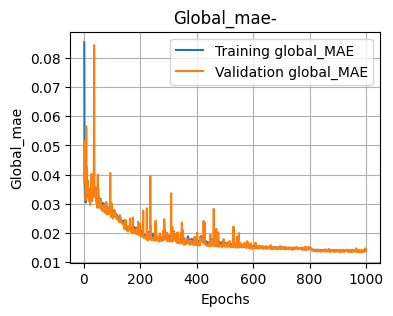

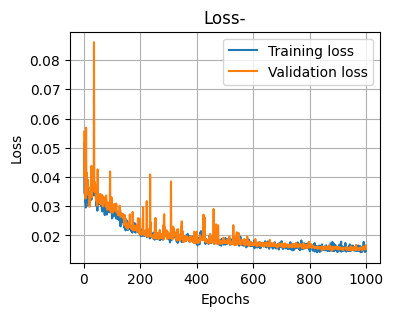

In [ ]:
from keras.callbacks import EarlyStopping
from keras import optimizers
# Stage 1: Reconstruction Model
# Instantiate autoencoder models
input_shape_li = [X_train_nor.shape[1:], X_train_delta_nor.shape[1:]]
encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)
# Compile and train autoencoder
training = MaskedReconstructionFit(autoencoder, alpha=1.0)
training.compile(optimizer=tf.optimizers.AdamW(1e-3, weight_decay=1e-4),
                #  metrics=[tf.keras.metrics.MeanAbsoluteError(name="global_MAE")]
                 )
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    mode='min',
    patience=50,          # Number of epochs to wait before stopping if no improvement
    verbose=1,           # Prints a message when training stops
    restore_best_weights=True,  # Restores the weights from the best epoch
    min_delta=1e-6
)
history = training.fit((X_train_nor, X_train_delta_nor), mask,
                        validation_data=((X_val_nor, X_val_delta_nor), mask_val),
                        epochs=1000, batch_size=128,
                        shuffle=True,
                        verbose=1,
                        # callbacks=[early_stopping]       # Pass the callback here
                        )
# Save the model
model_name = 'GRUMAE_nontruma_Jul28_1000'
save_models(encoders, autoencoder, save_dir=os.path.join(MODEL_FOLDER, model_name))

# Plot learning curves for the reconstruction model
plot_learning_curves(history)

# Evaluate reconstruction error
y_pred = autoencoder.predict([X_test_nor, X_test_delta_nor])
mae = tf.keras.metrics.MeanAbsoluteError(name="global_MAE")
mae.update_state(X_test_nor, y_pred)   # or simply  mae(X_test_nor, y_pred)
result = mae.result()                  # tf.Tensor scalar
print("MAE =", result.numpy())

In [ ]:
import pickle
path = os.path.join(MODEL_FOLDER, model_name, 'trainHistoryDict')
with open(path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

with open(path, "rb") as file_pi:
    model_history = pickle.load(file_pi)

In [ ]:
index = 800

global_MAE = history.history['global_MAE'][index:]
loss = history.history['loss'][index:]
val_global_MAE = history.history['val_global_MAE'][index:]
val_loss = history.history['val_loss'][index:]
epochs = np.arange(index+1, 1001)
# epochs.shape

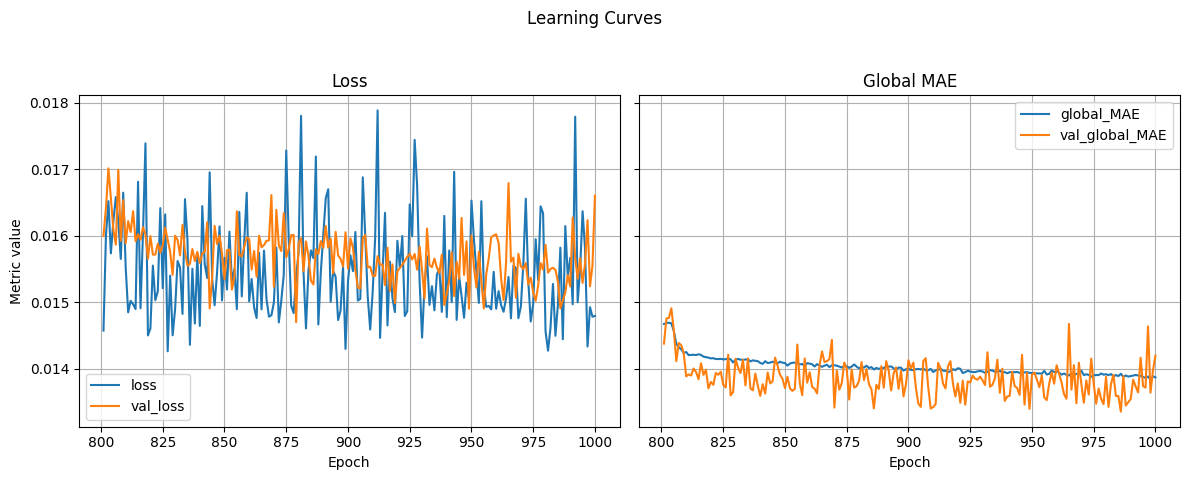

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

# ── left: loss ─────────────────────────────────────────────────────
axes[0].plot(epochs, loss,      label="loss")
axes[0].plot(epochs, val_loss,  label="val_loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Metric value")    # shown once because sharey=True
axes[0].grid(True)
axes[0].legend()

# ── right: global MAE ──────────────────────────────────────────────
axes[1].plot(epochs, global_MAE,     label="global_MAE")
axes[1].plot(epochs, val_global_MAE, label="val_global_MAE")
axes[1].set_title("Global MAE")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].legend()

fig.suptitle("Learning Curves")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Evaluating

In [ ]:
load_dir_path = os.path.join(MODEL_FOLDER, 'GRUMAE_nontruma_Jul28_1000')
encoders, autoencoder = load_models(load_dir_path, load_autoencoder=True)

Autoencoder loaded successfully from: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/GRUMAE_nontruma_Jul28_1000
Encoders loaded successfully from: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/GRUMAE_nontruma_Jul28_1000


In [ ]:
# inference
x_hat_nor = autoencoder.predict([X_test_nor, X_test_delta_nor])
mae = tf.keras.metrics.MeanAbsoluteError(name="global_MAE")
mae.update_state(X_test_nor, x_hat_nor)   # or simply  mae(X_test_nor, y_pred)
result = mae.result()                  # tf.Tensor scalar
print("MAE =", result.numpy())

543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
MAE = 0.014002132


In [ ]:
# de-normalise
x_hat = denormalize_with_trained_scaler(x_hat_nor, X_train)

In [ ]:
# visualisation
import math
import matplotlib.pyplot as plt

def plot_reconstruction_subplots(
    sample_ori: np.ndarray,
    sample_hat: np.ndarray,
    feature_names: list[str],
    start_hour: int = 18,
    ncols: int = 2,
    title_prefix: str = "Reconstruction vs. Original"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compare original and reconstructed night-time series feature-by-feature.

    Parameters
    ----------
    sample_ori, sample_hat : (T, F) arrays  –– original & reconstructed
    feature_names          : list of F feature labels
    start_hour             : first x-axis hour label (default 18 → 18:00)
    ncols                  : number of subplot columns
    """
    T, F = sample_ori.shape
    assert sample_hat.shape == sample_ori.shape, "Shapes must match (T, F)"

    # hour labels
    hour_labels = [f"{(start_hour + i) % 24:02d}:00" for i in range(T)]

    # tidy DataFrames for optional inspection
    df_ori = pd.DataFrame(sample_ori, columns=feature_names, index=hour_labels)
    df_hat = pd.DataFrame(sample_hat, columns=feature_names, index=hour_labels)

    # subplot grid
    nrows = math.ceil(F / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2 * nrows), sharex=False)
    axes_flat = axes.flatten()

    for idx, feat in enumerate(feature_names):
        ax = axes_flat[idx]
        ax.plot(range(T), df_ori[feat], label="Original",      linestyle="-")
        ax.plot(range(T), df_hat[feat], label="Reconstructed", linestyle="--")
        ax.set_ylabel(feat)
        ax.set_xticks(range(T))
        ax.set_xticklabels(hour_labels, rotation=45)
        ax.grid(True)

    # shared legend (upper-left, outside)
    ax.legend(["Original", "Reconstructed"],
              loc="upper left",
              fontsize="small",
              bbox_to_anchor=(1.02, 1),
              borderaxespad=0)

    # turn off any empty axes
    for ax in axes_flat[F:]:
        ax.axis("off")

    fig.suptitle(f"{title_prefix} per Feature", y=1.02)
    plt.tight_layout()
    plt.show()

    return


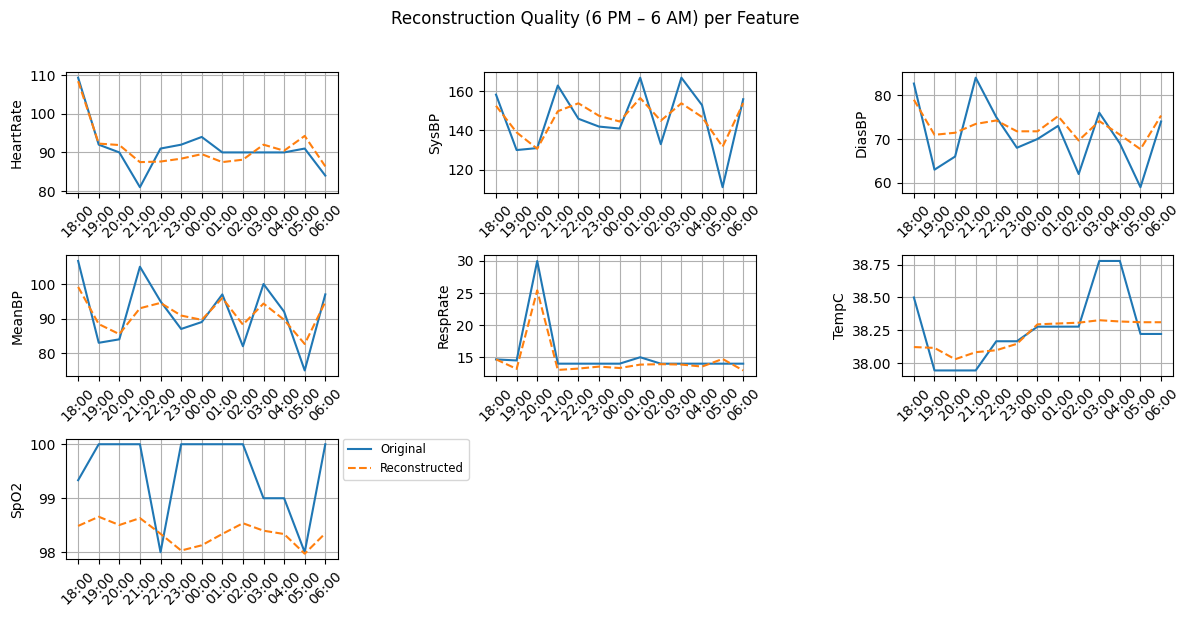

Sample-level MAE: 0.01399


In [ ]:
sample_idx   = 1                        # ← choose any test index
plot_reconstruction_subplots(
    X_test[sample_idx],
    x_hat[sample_idx],
    feature_names,
    start_hour=18,
    ncols=3,
    title_prefix="Reconstruction Quality (6 PM – 6 AM)"
)

# compute reconstruction loss
global_mae = mae.update_state(X_test_nor[sample_idx], X_test_nor[sample_idx])
print(f"Sample-level MAE: {mae.result():.5f}")

In [ ]:
X_test[sample_idx][:,-1]

array([ 99.33333333, 100.        , 100.        , 100.        ,
        98.        , 100.        , 100.        , 100.        ,
       100.        ,  99.        ,  99.        ,  98.        ,
       100.        ])

## training 2

**Goal: Set a “passing line” for yourself**

* **Data range.** After min-max scaling to (0.05 – 1.00), the dynamic range is $R = 0.95$.

* **Do-nothing baseline.** Always output the global mean (0.525).

  * For a roughly uniform distribution, this gives
  $$
  \text{MAE}_{\text{baseline}} \approx \tfrac{R}{4} \approx 0.24,\qquad
  $$
    
  * Any model with **MAE ≪ 0.24** and **MSE ≪ 0.075** beats the “do-nothing” baseline.

* **Practical target range (full reconstruction, no sensor noise).**

  * **MAE:** 0.01 – 0.03 (≈ 1 % – 3 % absolute error)

* **With 10 % random masking + masked training.**

  * A **masked MAE ≈ 0.02** is already solid;
  * Dropping to **≈ 0.01** means the model has captured most of the underlying structure.


In [ ]:
# Evaluate reconstruction error Before fine tune
y_pred = autoencoder.predict([X_test_nor, X_test_delta_nor])
mae = tf.keras.metrics.MeanAbsoluteError(name="global_MAE")
mae.update_state(X_test_nor, y_pred)   # or simply  mae(X_test_nor, y_pred)
result = mae.result()                  # tf.Tensor scalar
print("MAE =", result.numpy())

543/543 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
MAE = 0.014002132


Epoch 1/500
893/893 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - global_MAE: 0.0137 - loss: 0.0146 - val_global_MAE: 0.0129 - val_loss: 0.0147
Epoch 2/500
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0135 - loss: 0.0145 - val_global_MAE: 0.0128 - val_loss: 0.0147
Epoch 3/500
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0135 - loss: 0.0145 - val_global_MAE: 0.0128 - val_loss: 0.0147
Epoch 4/500
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0135 - loss: 0.0145 - val_global_MAE: 0.0128 - val_loss: 0.0147
Epoch 5/500
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0135 - loss: 0.0145 - val_global_MAE: 0.0128 - val_loss: 0.0146
Epoch 6/500
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0135 - loss: 0.0145 - val_global_MAE: 0.0128 - val_loss: 0.0146
Epoch 7/500
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - global_MAE: 0.0135 - loss: 0.0145 - val_global_MAE: 0.0128 - val_loss: 0.0146
Epoch 8/500
893/893 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step 

Models saved in: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/GRUMAE_nontruma_Jul28_1500
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
MAE = 0.0123472195


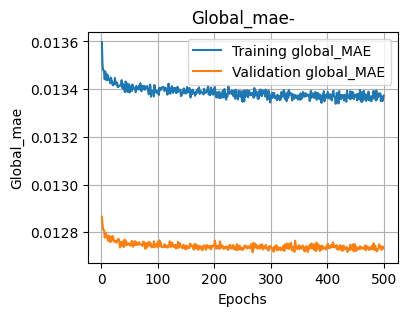

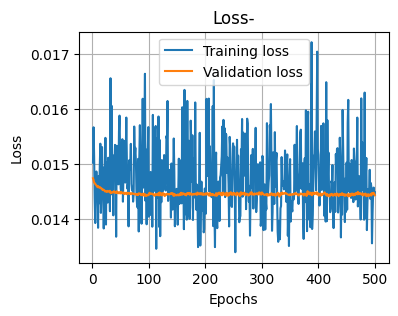

In [ ]:
from keras.callbacks import EarlyStopping
from keras import optimizers
# Stage 1: Reconstruction Model
# Instantiate autoencoder models
# input_shape_li = [X_train_nor.shape[1:], X_train_delta_nor.shape[1:]]
# encoders, autoencoder = multimodal_AutoEncoder(input_shape_li, drop_r=0.2)

# Compile and train autoencoder
training = MaskedReconstructionFit(autoencoder, alpha=1.0)
training.compile(optimizer=tf.optimizers.AdamW(1e-5, weight_decay=1e-4),
                #  metrics=[tf.keras.metrics.MeanAbsoluteError(name="global_MAE")]
                 )
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    mode='min',
    patience=50,          # Number of epochs to wait before stopping if no improvement
    verbose=1,           # Prints a message when training stops
    restore_best_weights=True,  # Restores the weights from the best epoch
    min_delta=1e-6
)
history = training.fit((X_train_nor, X_train_delta_nor), mask,
                        validation_data=((X_val_nor, X_val_delta_nor), mask_val),
                        epochs=500, batch_size=128,
                        shuffle=True,
                        verbose=1,
                        # callbacks=[early_stopping]       # Pass the callback here
                        )
# Save the model
model_name = 'GRUMAE_nontruma_Jul28_1500'
save_models(encoders, autoencoder, save_dir=os.path.join(MODEL_FOLDER, model_name))

# Plot learning curves for the reconstruction model
plot_learning_curves(history)

# Evaluate reconstruction error
y_pred = autoencoder.predict([X_test_nor, X_test_delta_nor])
mae = tf.keras.metrics.MeanAbsoluteError(name="global_MAE")
mae.update_state(X_test_nor, y_pred)   # or simply  mae(X_test_nor, y_pred)
result = mae.result()                  # tf.Tensor scalar
print("MAE =", result.numpy())

## Evaluating

In [ ]:
model_name = 'GRUMAE_nontruma_Jul28_1500'
load_dir_path = os.path.join(MODEL_FOLDER, 'GRUMAE_nontruma_Jul28_1500')
encoders, autoencoder = load_models(load_dir_path, load_autoencoder=True)

Autoencoder loaded successfully from: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/GRUMAE_nontruma_Jul28_1500
Encoders loaded successfully from: /content/drive/MyDrive/Colab Notebooks/All_ICU_notebook/Model/GRUMAE_nontruma_Jul28_1500


In [ ]:
# inference
x_hat_nor = autoencoder.predict([X_test_nor, X_test_delta_nor])
mae = tf.keras.metrics.MeanAbsoluteError(name="global_MAE")
mae.update_state(X_test_nor, x_hat_nor)   # or simply  mae(X_test_nor, y_pred)
result = mae.result()                  # tf.Tensor scalar
print("MAE =", result.numpy())

543/543 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
MAE = 0.01234478


In [ ]:
# de-normalise
x_hat = denormalize_with_trained_scaler(x_hat_nor, X_train)

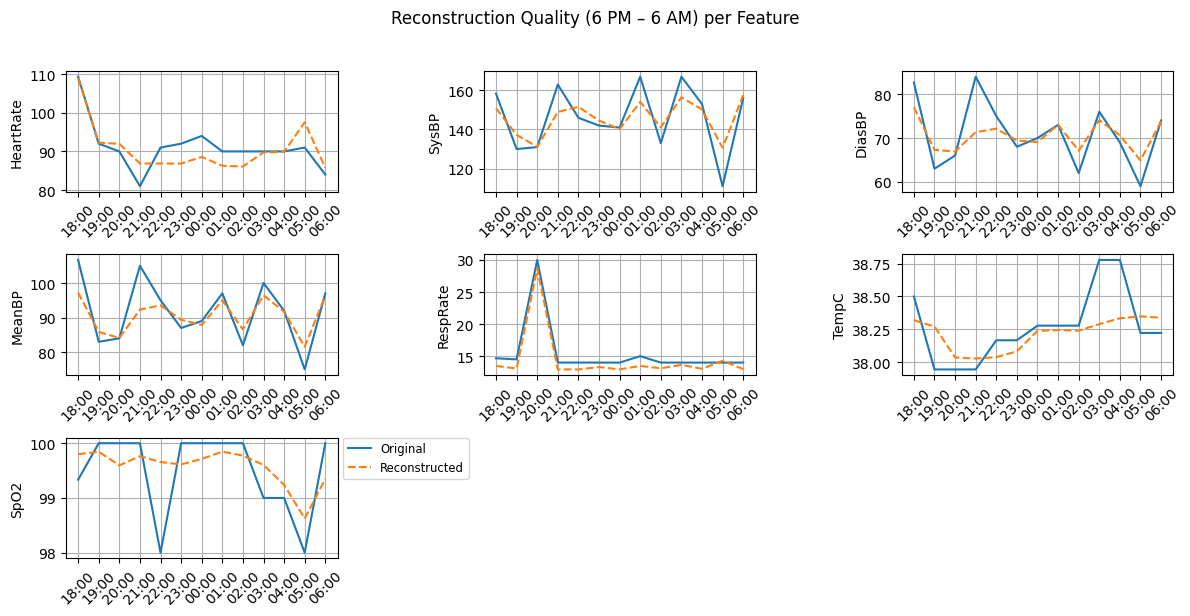

Sample-level MAE: 0.01234


In [ ]:
sample_idx   = 1                        # ← choose any test index
plot_reconstruction_subplots(
    X_test[sample_idx],
    x_hat[sample_idx],
    feature_names,
    start_hour=18,
    ncols=3,
    title_prefix="Reconstruction Quality (6 PM – 6 AM)"
)

# compute reconstruction loss
global_mae = mae.update_state(X_test_nor[sample_idx], X_test_nor[sample_idx])
print(f"Sample-level MAE: {mae.result():.5f}")

In [ ]:
import pickle
path = os.path.join(MODEL_FOLDER, model_name, 'trainHistoryDict')
# with open(path, 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

with open(path, "rb") as file_pi:
    model_history = pickle.load(file_pi)

In [ ]:
path = os.path.join(MODEL_FOLDER, model_name, 'trainHistoryDict')

with open(path, "rb") as file_pi:
    model_history = pickle.load(file_pi)

In [ ]:
index = 400

history_data = model_history

global_MAE = history_data['global_MAE'][index:]
loss = history_data['loss'][index:]
val_global_MAE = history_data['val_global_MAE'][index:]
val_loss = history_data['val_loss'][index:]
epochs = np.arange(index+1, 501)
# epochs.shape

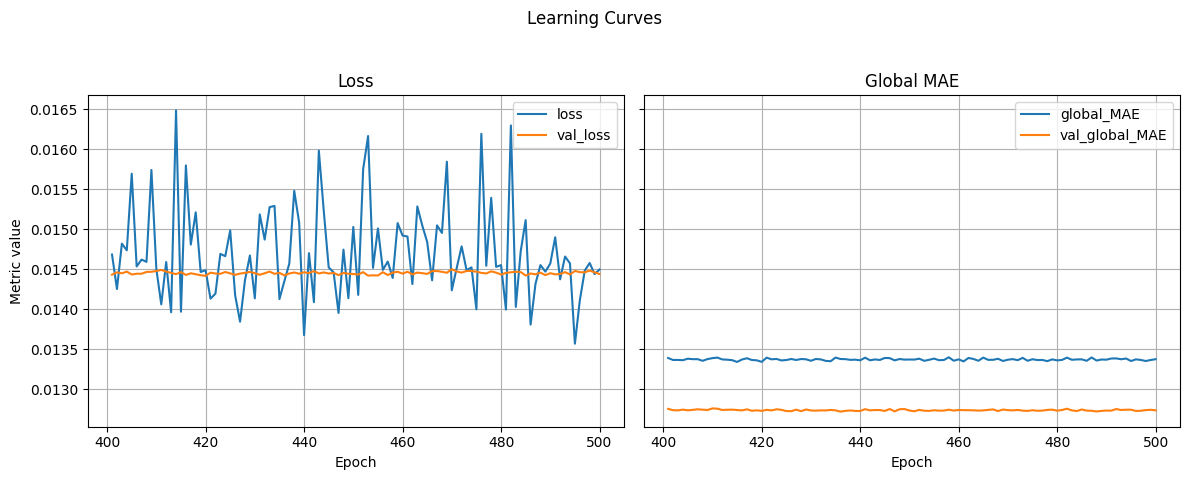

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

# ── left: loss ─────────────────────────────────────────────────────
axes[0].plot(epochs, loss,      label="loss")
axes[0].plot(epochs, val_loss,  label="val_loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Metric value")    # shown once because sharey=True
axes[0].grid(True)
axes[0].legend()

# ── right: global MAE ──────────────────────────────────────────────
axes[1].plot(epochs, global_MAE,     label="global_MAE")
axes[1].plot(epochs, val_global_MAE, label="val_global_MAE")
axes[1].set_title("Global MAE")
axes[1].set_xlabel("Epoch")
axes[1].grid(True)
axes[1].legend()

fig.suptitle("Learning Curves")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()